<a target="_blank" href="https://colab.research.google.com/github/vishalbakshi/passage-spanner/blob/main/PassageSpanner.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
from itertools import combinations
from fastcore.utils import L,groupby,patch,store_attr,BasicRepr
from fastcore.test import test_eq
from regex import finditer, escape
import requests, json

## Background

The purpose of this tool (which I'm calling _PassageSpanner_ for lack of a better name) is to extract text from a document including and in between two retrieved passages. This notebook walks through my initial solution using fake data on various edge cases.

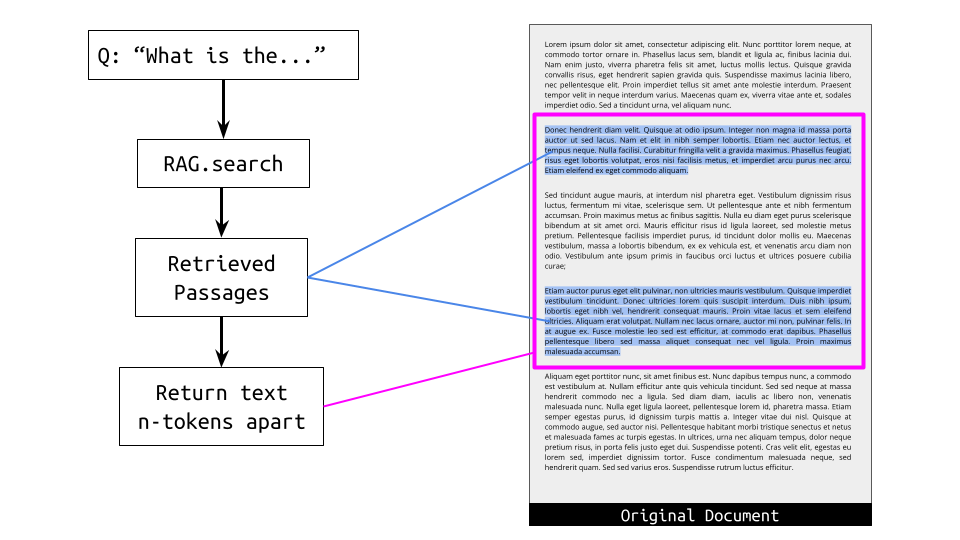

I've sketched out the following six sample use cases. This notebook implements a solution for use case 3. If this solution looks good, I'll move on to 4.


**Sample Use Case 0**

- Make up a query, a document with 4-5 paragraphs, and a list with two hardcoded passages.
- Extract text from the document including and in between the two hardcoded passages.

**Sample Use Case 1**

- Create a list of 10 passages (including the two relevant ones from use case 0).
- Extract relevant text from document.

**Sample Use Case 2**

- Pick some number of characters `max_dist`, say 20.
- From the original document, extract the text including and in between only the two relevant passages that are less than `max_dist` characters apart.

**Sample Use Case 3**

- Test out this functionality on fastbook-benchmark, for answerai-colbert-small-v1's actual retrieval results. Select relevant passages only for this use case. This served as an additional check of my retrieval code.

**Sample Use Case 4**

- Repeat Use Case 3 but for all 10 retrieved passages for those questions.

**Sample Use Case 5**

- Currently I store spans for each unique starting passage. After looking at a bunch of retrieval results, I think it makes sense to only keep the longest span based on unique ending passage. See Chapter 4 Question 20 below for an example of this.
- Repeat Sample Use Case 4 but instead of `max_dist` characters, use `max_dist` tokens.


In [2]:
document = """The quick brown fox jumps over the lazy dog.
The quick brown fox runs through the field.
A lazy dog sleeps in the sun."""

passages = [
    "quick brown fox",
    "lazy dog",
    "this passage is not in the document"
]
document, passages

('The quick brown fox jumps over the lazy dog.\nThe quick brown fox runs through the field.\nA lazy dog sleeps in the sun.',
 ['quick brown fox', 'lazy dog', 'this passage is not in the document'])

## Passage

The main object that I'm working with is a `Passage` which holds four important pieces of information:

- `text`: the passage text
- `start_pos`: the integer start position of the passage in the document
- `length`: the passage length
- `end_pos`: the integer end position of the passage in the document

In [3]:
passage = passages[0]
passage

'quick brown fox'

In [4]:
document.find(passage)

4

In [5]:
len(passage)

15

In [6]:
document.find(passage) + len(passage) - 1

18

In [7]:
class Passage(BasicRepr):
    def __init__(self, text, start_pos, length): store_attr()

In [8]:
p = Passage(passage, document.find(passage), len(passage))
p

Passage(text='quick brown fox', start_pos=4, length=15)

In [9]:
@patch(as_prop=True)
def end_pos(self:Passage): return self.start_pos if self.length == 0 else self.start_pos + self.length - 1

In [10]:
p.end_pos

18

In [11]:
def _passage(text, start_pos, length): return Passage(text=text, start_pos=start_pos, length=length)

In [12]:
p = _passage(passage, document.find(passage), len(passage))
p, p.end_pos

(Passage(text='quick brown fox', start_pos=4, length=15), 18)

## Span

The next core object that I'm working with is a span which holds three pieces of information:

- `start` Passage
- `end` Passage
- `distance` between the two (distance = the difference between the first character of the ending Passage and the last character of the starting Passage)

In [13]:
start = p
start

Passage(text='quick brown fox', start_pos=4, length=15)

In [14]:
passage = passages[1]
passage

'lazy dog'

In [15]:
end = _passage(passage, document.find(passage), len(passage))
end

Passage(text='lazy dog', start_pos=35, length=8)

In [16]:
distance = end.start_pos - start.end_pos
distance

17

In [17]:
class Span(BasicRepr):
    def __init__(self, start, end): store_attr()

In [18]:
s = Span(start, end)
s

Span(start=Passage(text='quick brown fox', start_pos=4, length=15), end=Passage(text='lazy dog', start_pos=35, length=8))

In [19]:
@patch(as_prop=True)
def distance(self:Span): return self.end.start_pos - self.start.end_pos

In [20]:
s.distance

17

In [21]:
def _span(start, end): return Span(start, end)

In [22]:
s = _span(start, end)
s, s.distance

(Span(start=Passage(text='quick brown fox', start_pos=4, length=15), end=Passage(text='lazy dog', start_pos=35, length=8)),
 17)

## Converting a list of passages to Passages

In [23]:
document

'The quick brown fox jumps over the lazy dog.\nThe quick brown fox runs through the field.\nA lazy dog sleeps in the sun.'

In [24]:
passages

['quick brown fox', 'lazy dog', 'this passage is not in the document']

A passage may occur multiple times in a document as this example shows, we want to capture all occurences as a unique Passage.

In [25]:
passage = passages[0]
passage

'quick brown fox'

In [26]:
L(finditer(escape(passage), document))

(#2) [<regex.Match object; span=(4, 19), match='quick brown fox'>,<regex.Match object; span=(49, 64), match='quick brown fox'>]

In [27]:
def _find(passage, document): return L(finditer(escape(passage), document))

In [28]:
ms = _find(passage, document)
ms

(#2) [<regex.Match object; span=(4, 19), match='quick brown fox'>,<regex.Match object; span=(49, 64), match='quick brown fox'>]

I want to extract from each match the text, start index and length of text:

In [29]:
m = ms[0]
m

<regex.Match object; span=(4, 19), match='quick brown fox'>

In [30]:
(m.group(), m.start(), len(m.group()))

('quick brown fox', 4, 15)

In [31]:
def _parsematch(m): return (m.group(), m.start(), len(m.group()))

In [32]:
_parsematch(m)

('quick brown fox', 4, 15)

Putting it all together for multiple passages with multiple occurences in the document:

In [33]:
L(passages).map(_find, document=document)

(#3) [[<regex.Match object; span=(4, 19), match='quick brown fox'>, <regex.Match object; span=(49, 64), match='quick brown fox'>],[<regex.Match object; span=(35, 43), match='lazy dog'>, <regex.Match object; span=(91, 99), match='lazy dog'>],[]]

The empty list is for the passage that was not in the document, and will go away when using `concat`.

In [34]:
passages[-1], _find(passages[-1], document)

('this passage is not in the document', (#0) [])

In [35]:
L(passages).map(_find, document=document).concat()

(#4) [<regex.Match object; span=(4, 19), match='quick brown fox'>,<regex.Match object; span=(49, 64), match='quick brown fox'>,<regex.Match object; span=(35, 43), match='lazy dog'>,<regex.Match object; span=(91, 99), match='lazy dog'>]

In [36]:
L(passages).map(_find, document=document).concat().map(_parsematch)

(#4) [('quick brown fox', 4, 15),('quick brown fox', 49, 15),('lazy dog', 35, 8),('lazy dog', 91, 8)]

In [37]:
L(passages).map(_find, document=document).concat().map(_parsematch).starmap(_passage)

(#4) [Passage(text='quick brown fox', start_pos=4, length=15),Passage(text='quick brown fox', start_pos=49, length=15),Passage(text='lazy dog', start_pos=35, length=8),Passage(text='lazy dog', start_pos=91, length=8)]

Lastly, I want to sort by start position (ascending) as I'm interested in eventually extracting consecutive passages from the document.

In [38]:
ps = L(passages).map(_find, document=document).concat().map(_parsematch).starmap(_passage).sorted(key=lambda p: p.start_pos)
ps

(#4) [Passage(text='quick brown fox', start_pos=4, length=15),Passage(text='lazy dog', start_pos=35, length=8),Passage(text='quick brown fox', start_pos=49, length=15),Passage(text='lazy dog', start_pos=91, length=8)]

## Creating Spans from all Passage combinations

The document may contain any Span of two Passages, so we want all of them.

In [39]:
combs = L(combinations(ps, 2))
combs

(#6) [(Passage(text='quick brown fox', start_pos=4, length=15), Passage(text='lazy dog', start_pos=35, length=8)),(Passage(text='quick brown fox', start_pos=4, length=15), Passage(text='quick brown fox', start_pos=49, length=15)),(Passage(text='quick brown fox', start_pos=4, length=15), Passage(text='lazy dog', start_pos=91, length=8)),(Passage(text='lazy dog', start_pos=35, length=8), Passage(text='quick brown fox', start_pos=49, length=15)),(Passage(text='lazy dog', start_pos=35, length=8), Passage(text='lazy dog', start_pos=91, length=8)),(Passage(text='quick brown fox', start_pos=49, length=15), Passage(text='lazy dog', start_pos=91, length=8))]

In [40]:
combs[0]

(Passage(text='quick brown fox', start_pos=4, length=15),
 Passage(text='lazy dog', start_pos=35, length=8))

In [41]:
combs.starmap(_span)

(#6) [Span(start=Passage(text='quick brown fox', start_pos=4, length=15), end=Passage(text='lazy dog', start_pos=35, length=8)),Span(start=Passage(text='quick brown fox', start_pos=4, length=15), end=Passage(text='quick brown fox', start_pos=49, length=15)),Span(start=Passage(text='quick brown fox', start_pos=4, length=15), end=Passage(text='lazy dog', start_pos=91, length=8)),Span(start=Passage(text='lazy dog', start_pos=35, length=8), end=Passage(text='quick brown fox', start_pos=49, length=15)),Span(start=Passage(text='lazy dog', start_pos=35, length=8), end=Passage(text='lazy dog', start_pos=91, length=8)),Span(start=Passage(text='quick brown fox', start_pos=49, length=15), end=Passage(text='lazy dog', start_pos=91, length=8))]

I only want to keep Spans that are less than or equal to `max_dist`

In [42]:
max_dist=20
spans = combs.starmap(_span).filter(lambda s: s.distance <= max_dist)
spans

(#2) [Span(start=Passage(text='quick brown fox', start_pos=4, length=15), end=Passage(text='lazy dog', start_pos=35, length=8)),Span(start=Passage(text='lazy dog', start_pos=35, length=8), end=Passage(text='quick brown fox', start_pos=49, length=15))]

## Storing the longest Spans

Each Passage may start one or more Spans. I want the longest Span for each starting Passage.

In [43]:
gs = groupby(spans, lambda s: s.start.start_pos)
gs

{4: [Span(start=Passage(text='quick brown fox', start_pos=4, length=15), end=Passage(text='lazy dog', start_pos=35, length=8))],
 35: [Span(start=Passage(text='lazy dog', start_pos=35, length=8), end=Passage(text='quick brown fox', start_pos=49, length=15))]}

In this case there is only valid Span per starting position under `max_dist`.

In [44]:
L(max(g, key=lambda s: s.end.end_pos) for g in gs.values())

(#2) [Span(start=Passage(text='quick brown fox', start_pos=4, length=15), end=Passage(text='lazy dog', start_pos=35, length=8)),Span(start=Passage(text='lazy dog', start_pos=35, length=8), end=Passage(text='quick brown fox', start_pos=49, length=15))]

For illustrative purposes, I'll show my `max` operation on all Spans (even those greater than `max_dist`)

In [45]:
gs2 = groupby(combs.starmap(_span), lambda s: s.start.start_pos)
gs2

{4: [Span(start=Passage(text='quick brown fox', start_pos=4, length=15), end=Passage(text='lazy dog', start_pos=35, length=8)),
  Span(start=Passage(text='quick brown fox', start_pos=4, length=15), end=Passage(text='quick brown fox', start_pos=49, length=15)),
  Span(start=Passage(text='quick brown fox', start_pos=4, length=15), end=Passage(text='lazy dog', start_pos=91, length=8))],
 35: [Span(start=Passage(text='lazy dog', start_pos=35, length=8), end=Passage(text='quick brown fox', start_pos=49, length=15)),
  Span(start=Passage(text='lazy dog', start_pos=35, length=8), end=Passage(text='lazy dog', start_pos=91, length=8))],
 49: [Span(start=Passage(text='quick brown fox', start_pos=49, length=15), end=Passage(text='lazy dog', start_pos=91, length=8))]}

In [46]:
L(max(g, key=lambda s: s.end.end_pos) for g in gs2.values())

(#3) [Span(start=Passage(text='quick brown fox', start_pos=4, length=15), end=Passage(text='lazy dog', start_pos=91, length=8)),Span(start=Passage(text='lazy dog', start_pos=35, length=8), end=Passage(text='lazy dog', start_pos=91, length=8)),Span(start=Passage(text='quick brown fox', start_pos=49, length=15), end=Passage(text='lazy dog', start_pos=91, length=8))]

Wrapping this in a function:

In [47]:
def longest(spans):
    gs = groupby(spans, lambda s: s.start.start_pos)
    return L(max(g, key=lambda s: s.end.end_pos) for g in gs.values())

In [48]:
longest(spans)

(#2) [Span(start=Passage(text='quick brown fox', start_pos=4, length=15), end=Passage(text='lazy dog', start_pos=35, length=8)),Span(start=Passage(text='lazy dog', start_pos=35, length=8), end=Passage(text='quick brown fox', start_pos=49, length=15))]

## Extracting Span from document

The text from the document is extracted like so:

In [49]:
span = longest(spans)[0]
span

Span(start=Passage(text='quick brown fox', start_pos=4, length=15), end=Passage(text='lazy dog', start_pos=35, length=8))

In [50]:
document[span.start.start_pos:span.end.end_pos+1]

'quick brown fox jumps over the lazy dog'

## Tests

I've manually checked these test cases [here](https://github.com/vishalbakshi/passage-spanner/blob/main/test%20cases.md).

The retrieval results using answerai-colbert-small-v1 are in [this gist](https://gist.github.com/vishalbakshi/d12aabb6e62ace021e6d2c680b3f7b7a). The manually calculated final spans are in [this file](https://github.com/vishalbakshi/passage-spanner/blob/main/retrieval_results.md).

In [51]:
class Passage(BasicRepr):
    def __init__(self, text, start_pos, length): store_attr()

@patch(as_prop=True)
def end_pos(self:Passage): return self.start_pos if self.length == 0 else self.start_pos + self.length - 1

class Span(BasicRepr):
    def __init__(self, start, end): store_attr()

@patch(as_prop=True)
def distance(self:Span): return self.end.start_pos - self.start.end_pos

In [52]:
def _parsematch(m): return (m.group(), m.start(), len(m.group()))
def _find(passage, document): return L(finditer(escape(passage), document))

def _passage(text, start_pos, length): return Passage(text=text, start_pos=start_pos, length=length)
def _span(start, end): return Span(start, end)

def longest(spans):
    gs = groupby(spans, lambda s: s.start.start_pos)
    return L(max(g, key=lambda s: s.end.end_pos) for g in gs.values())

def _text(doc, passages, max_dist=20):
    ps = L(passages).map(_find, document=doc).concat().map(_parsematch).starmap(_passage).sorted(key=lambda p: p.start_pos)
    combs = L(combinations(ps, 2))
    spans = longest(combs.starmap(_span).filter(lambda s: s.distance <= max_dist))
    return L(doc[s.start.start_pos:s.end.end_pos+1] for s in spans)

### Overlapping passages

In [53]:
document = """The quick brown fox jumps over the lazy dog.
A clever fox leaps across the sleeping hound.
The nimble creature bounds through the garden."""

passages = [
    "brown fox jumps over",
    "fox jumps over the lazy",
    "over the lazy dog.\nA clever",
    "the lazy dog",
    "sleeping hound.\nThe nimble"
]

expected = L(['brown fox jumps over the lazy dog.\nA clever','fox jumps over the lazy dog.\nA clever','over the lazy dog'])
document, passages

('The quick brown fox jumps over the lazy dog.\nA clever fox leaps across the sleeping hound.\nThe nimble creature bounds through the garden.',
 ['brown fox jumps over',
  'fox jumps over the lazy',
  'over the lazy dog.\nA clever',
  'the lazy dog',
  'sleeping hound.\nThe nimble'])

In [54]:
res = _text(document, passages)
test_eq(res, expected)

In [55]:
document = """Once upon a time, a magical crystal glowed brightly.
Its light danced across the ancient cavern walls.
Deep within, secrets waited to be discovered."""

passages = [
    "magical crystal",           # first in chain
    "crystal glowed",           # overlaps with previous
    "glowed brightly",          # overlaps with previous
    "brightly.\nIts light",     # overlaps with previous, crosses line
    "light danced",             # overlaps with previous
    "Deep within",              # separate passage
    "to be discovered"          # separate passage
]


expected = L([
    'magical crystal glowed brightly.\nIts light',
    'crystal glowed brightly.\nIts light danced',
    'glowed brightly.\nIts light danced','brightly.\nIts light danced',
    'Deep within, secrets waited to be discovered'
    ])
document, passages

('Once upon a time, a magical crystal glowed brightly.\nIts light danced across the ancient cavern walls.\nDeep within, secrets waited to be discovered.',
 ['magical crystal',
  'crystal glowed',
  'glowed brightly',
  'brightly.\nIts light',
  'light danced',
  'Deep within',
  'to be discovered'])

In [56]:
res = _text(document, passages)
test_eq(res, expected)

### Repeated passages

In [57]:
document = """The quick brown fox jumps over the lazy dog.
The quick brown fox runs through the field.
A lazy dog sleeps in the sun."""

passages = [
    "quick brown fox",  # Appears twice
    "lazy dog"         # Appears twice
]

expected = L(['quick brown fox jumps over the lazy dog','lazy dog.\nThe quick brown fox'])
document, passages

('The quick brown fox jumps over the lazy dog.\nThe quick brown fox runs through the field.\nA lazy dog sleeps in the sun.',
 ['quick brown fox', 'lazy dog'])

In [58]:
res = _text(document, passages)
test_eq(res, expected)

### Empty passages

In [59]:
document = "doc"
passages = [""]
expected = L(['doc','oc','c'])
document, passages

('doc', [''])

In [60]:
res = _text(document, passages)
test_eq(res, expected)

### Passages with whitespace characters

In [61]:
document = "This is a\nsample\tdocument with some content."
passages = [" ", "   ", "\n", "\t"]
expected = L([' is a\nsample\t',' a\nsample\tdocument ','\nsample\tdocument ','\tdocument with some ',' with some ',' some '])
document, passages

('This is a\nsample\tdocument with some content.', [' ', '   ', '\n', '\t'])

In [62]:
res = _text(document, passages)
test_eq(res, expected)

### Passages with special characters or formatting

In [63]:
document = """Special *formatting* and (punctuation) test!
Some text with @#$% special chars.
More text with <html> tags and line-breaks
    plus some indentation."""
passages = [
    "*formatting*",
    "@#$%",
    "<html>",
    "    plus"
]

expected = L([])
document, passages

('Special *formatting* and (punctuation) test!\nSome text with @#$% special chars.\nMore text with <html> tags and line-breaks\n    plus some indentation.',
 ['*formatting*', '@#$%', '<html>', '    plus'])

In [64]:
res = _text(document, passages)
test_eq(res, expected)

### Non-existent passages

In [65]:
document = """The sky is blue.
The grass is green.
The sun is yellow.
The rose is red.
The cloud is white."""

passages = [
    "The sky is blue.",
    "The grass is green.",
    "This passage is not in the document.",
    "The sun is yellow.",
    "The rose is red.",
    "The cloud is white.",
    "This passage is also not in the document."
]

expected = L(["The sky is blue.\nThe grass is green.",
"The grass is green.\nThe sun is yellow.",
"The sun is yellow.\nThe rose is red.\nThe cloud is white.",
"The rose is red.\nThe cloud is white."])
document, passages

('The sky is blue.\nThe grass is green.\nThe sun is yellow.\nThe rose is red.\nThe cloud is white.',
 ['The sky is blue.',
  'The grass is green.',
  'This passage is not in the document.',
  'The sun is yellow.',
  'The rose is red.',
  'The cloud is white.',
  'This passage is also not in the document.'])

In [66]:
res = _text(document, passages)
test_eq(res, expected)

### Actual Retrieval Results

The retrieval results using answerai-colbert-small-v1 are in [this gist](https://gist.github.com/vishalbakshi/d12aabb6e62ace021e6d2c680b3f7b7a). The manually calculated final spans are in [this file for relevant retrieved passages](https://github.com/vishalbakshi/passage-spanner/blob/main/retrieval_results.md) and [this file for all retrieved passages](https://github.com/vishalbakshi/passage-spanner/blob/main/all_retrieval_results.md).

In [67]:
url = "https://gist.githubusercontent.com/vishalbakshi/d12aabb6e62ace021e6d2c680b3f7b7a/raw/0db3ee0175cbbb5546e302890f275ecdd6d44a79/fastbook-benchmark-answerai-retrieval.json"
fn = 'results.json'
with open(fn, 'wb') as file: file.write(requests.get(url).content)
with open(fn, 'r') as f: results = json.load(f)

In [68]:
def get_chapter_document(fn, url):
    with open(fn, 'wb') as file: file.write(requests.get(url).content)
    with open(fn, "r") as file:
        document = file.read()
        return document

In [69]:
def get_item(results, idx):
    item = results[idx]
    ch = int(item['chapter'])
    qn = int(item['question_number'])
    print(f"Chapter {ch} Question {qn}")
    return item

In [70]:
def relevant_passages(item, idxs):
    passages = item['answerai_retrieval']
    return [passages[i] for i in idxs]

In [71]:
def check_res(res):
    for r in res:
        print(r[:25], '||', r[-25:])

#### Chapter 1 Question 20

In [72]:
fn = 'chapter_1.txt'
url = "https://gist.githubusercontent.com/vishalbakshi/512930003f1d1710827c841749e0a981/raw/64856bb726d5985a7bf62aadcf3706b338c103a9/chapter_1.txt"
document = get_chapter_document(fn, url)

In [73]:
item = get_item(results, 16)

Chapter 1 Question 20


##### Relevant Retrieval Results

In [74]:
passages = relevant_passages(item, [0, 2, 3, 9])

In [75]:
res = _text(document, passages, max_dist=2000)
test_eq(res, item['relevant_expected'])

In [76]:
check_res(res)

(We’ll even take you step || s in your validation set.
Splitting off our validat || simple model can achieve.


##### All Retrieval Results

In [77]:
passages = relevant_passages(item, list(range(10)))

In [78]:
res = _text(document, passages, max_dist=2000)
test_eq(res, item['all_expected'])

In [79]:
check_res(res)

That is always our goal w || et starts getting worse).
*Machine learning* is a d || is called *segmentation*.
(We’ll even take you step || s in your validation set.
Splitting off our validat || simple model can achieve.
The test and validation s || pear in the training set.
(It's also a good idea fo || h order you read them in.
<img src="images/timeseri || h order you read them in.


#### Chapter 2 Question 22

In [80]:
fn = 'chapter_2.txt'
url = "https://gist.githubusercontent.com/vishalbakshi/1a6423b97f4b27fde8449788a589de68/raw/72fb53c6a8e49a08143e7f589b06c3c55a35b807/chapter_2.txt"
document = get_chapter_document(fn, url)

In [81]:
item = get_item(results, 50)

Chapter 2 Question 22


##### Relevant Retrieval Results

In [82]:
passages = relevant_passages(item, [0, 1, 2])

In [83]:
res = _text(document, passages, max_dist=2000)
test_eq(res, item['relevant_expected'])

In [84]:
check_res(res)

So what's left is a web a || nutes to build your site.


##### All Retrieval Results

In [85]:
passages = relevant_passages(item, list(range(10)))

In [86]:
res = _text(document, passages, max_dist=2000)
test_eq(res, item['all_expected'])

#### Chapter 4 Question 20

##### Relevant Retrieved Passages

In [87]:
fn = 'chapter_4.txt'
url = "https://gist.githubusercontent.com/vishalbakshi/13b8481f446289df639e82655201bd93/raw/159038696f05d645eb37d63c6c2ff479c9b5635d/chapter_4.txt"
document = get_chapter_document(fn, url)

In [88]:
item = get_item(results, 73)

Chapter 4 Question 20


In [89]:
passages = relevant_passages(item, [0, 8])

In [90]:
res = _text(document, passages, max_dist=2000)
test_eq(res, item['relevant_expected'])

In [91]:
check_res(res)

The problem is that a sma ||  loss function is better.


##### All Retrieved Passages

In [92]:
passages = relevant_passages(item, list(range(10)))

In [93]:
res = _text(document, passages, max_dist=2000)
test_eq(res, item['all_expected'])

In [94]:
check_res(res)

Let's check our accuracy. ||  loss function is better.
The problem is that a sma || why did we define a loss?
It is also a vector (i.e. || ance on that single item.
In PyTorch, we always ass || ance on that single item.
This is known as the *uni || l contained in *tensors*.
A function that can solve || l contained in *tensors*.


#### Chapter 10 Question 6

In [95]:
fn = 'chapter_10.txt'
url = "https://gist.githubusercontent.com/vishalbakshi/b862ddb53e90e24a81f0a0f56531008f/raw/0d8efac9b6782e48090294bf4875d68cc842241b/chapter_10.txt"
document = get_chapter_document(fn, url)

In [96]:
item = get_item(results, 142)

Chapter 10 Question 6


##### Relevant Retrieved Passages

In [97]:
passages = relevant_passages(item, [0, 5, 8])

In [98]:
res = _text(document, passages, max_dist=2000)
test_eq(res, item['relevant_expected'])

In [99]:
check_res(res)

##### All Retrieved Passages

In [100]:
passages = relevant_passages(item, list(range(10)))

In [101]:
res = _text(document, passages, max_dist=2000)
test_eq(res, item['all_expected'])

In [102]:
check_res(res)

The Wikipedia English is  || s from many, many pieces?
Using this approach, we h || s from many, many pieces?
Since `fine_tune` doesn't || g the first 10 documents.
We can now use it to fine || g the first 10 documents.
A classifier, however, pr || nce just three years ago.


#### Chapter 13 Question 17

In [103]:
fn = 'chapter_13.txt'
url = "https://gist.githubusercontent.com/vishalbakshi/d7b05b7bd21c0d2b41ef33c5bf2c3157/raw/9cb2754efc05085ccc1a47e3d1d6c5dab86f55cc/chapter_13.txt"
document = get_chapter_document(fn, url)

In [104]:
item = get_item(results, 170)

Chapter 13 Question 17


##### Relevant Retrieved Passages

In [105]:
passages = relevant_passages(item, [0, 1])

In [106]:
res = _text(document, passages, max_dist=2000)
test_eq(res, item['relevant_expected'])

In [107]:
check_res(res)

If we left the number of  || or images.
### A Note Abo


##### All Retrieved Passages

In [108]:
passages = relevant_passages(item, list(range(10)))

In [109]:
res = _text(document, passages, max_dist=2000)
test_eq(res, item['all_expected'])

In [110]:
check_res(res)

We can see we get the sam || oing to show it here too!
That's because a linear l || d less as it gets deeper.
_Features_ is never used  || since we have two layers.
### Understanding Convolu || or images.
### A Note Abo
If we left the number of  || or images.
### A Note Abo
We did do that in the `ge || well! Let's find out why.


##### code to check where discrepancies exist

In [ ]:
item['all_expected'][5] == res[5]

In [183]:
actual = res[3]
expected = item['all_expected'][3]
for i, char in enumerate(expected):
    if expected[i] != actual[i]:
        print(i, expected[i], actual[i])


844 ' ’


In [184]:
res[3][840:890]

' don’t really need our own. This is an important f'

In [179]:
item['all_expected'][3][:50]

'It is also a vector (i.e., another rank-1 tensor),'